# <center>  GEOS3009/3909 – COASTAL ENVIRONMENTS AND PROCESSES

## <center>   PRACTICAL – PROCESSING WAVE DATA
    
<br>
<br>
<br>


### Notebook 2: Wave Analysis
<br>

<font size="3">
Now our data is ready to be analysed!

</font>

Import some libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import cm
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.mlab as mlab
from scipy.signal import hann 
from pyfftw.interfaces import scipy_fftpack as fftw

C:\Users\lachl\AppData\Local\Temp\ipykernel_9536\2982520754.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [4]:
#Import the csv's we created in the previous notebook:
malabar = pd.read_csv('..\data\mal_data.csv')

#Convert to datetime again
malabar['dates'] = pd.to_datetime(malabar['dates'])

In [5]:
malabar.head()

,dates,pressure
0,2021-04-16 14:30:00.000,11.2756
1,2021-04-16 14:30:00.125,11.2798
2,2021-04-16 14:30:00.250,11.2797
3,2021-04-16 14:30:00.375,11.2714
4,2021-04-16 14:30:00.500,11.2597


## Reshape data for spectral analyses


Let's look at Malabar:

In [6]:
Hz = 8. # sample freq.
rl = 5 # minutes
dt = 1./Hz
bl = int((rl/dt)*60.) # burst length
nbl = int(math.floor(len(malabar)/bl))

# Reshape data
time = malabar.dates[0:nbl*bl].values.reshape((bl,nbl), order='F')
press = malabar['pressure'][0:nbl*bl].values.reshape((bl,nbl), order='F')

mean_pressure = press.mean(axis=0)



## Set up some functions:

In [7]:
def PT_power(x, dt, h=0):
    
    n = len(x)
    xd = mlab.detrend(x)
    
    if h > 0:
        xd = xd*hann(n+2)[1:-1]

    xn = fftw.fft(xd,n)
    if h > 0:
        xn = xn*np.sqrt(8/3)
        
    pxx = dt*(xn*np.conj(xn))/n
    
    paa = np.sqrt(xn*np.conj(xn))/n
    pxx = dt*(xn*np.conj(xn))/n
    
    nf= int(np.fix((n/2)+1))
    px=2.0 * pxx[0:nf]
    pa=2.0 * paa[0:nf]
    step = 1/(n*dt)
    f = np.arange(0, 1/(2.*dt)+step, step)[0:-1]
    
    return px, f, pa 

def Wwaves_spectral_RBR(px_in,f_in,dt):
    
    n21 = len(px_in)
    n = (n21-1)*2
    
    jj = np.argwhere((f_in>=0.33)&(f_in<1))[:,0]
    
    f = f_in[jj]
    px = px_in[jj]
    
    m0 = np.sum(px)/(n*dt)
    m1 = np.sum(f*px)/(n*dt);
    m2 = np.sum((f**2)*px)/(n*dt)
    m4 = np.sum((f**4)*px)/(n*dt)
    
    hs = 4.*np.sqrt(m0)
    hrms = np.sqrt(8.*m0)
    tm02 = np.sqrt(m0/m2)
    tm01 = m0/m1
    eps = np.sqrt(1.-(m2**2)/(m0*m4))
    hmax = 2.*hs
    
    ii = np.argwhere(f>=0.33)[:,0]
    fc = f[ii]
    pxc = px[ii]
    j = np.abs(pxc).argmax()
    tpeak = 1/fc[j]
    
    return hs, hrms, hmax, tm01, tm02, tpeak, eps


def Gwaves_spectral_RBR(px_in,f_in,dt):
    
    n21 = len(px_in)
    n = (n21-1)*2
    
    jj = np.argwhere((f_in>=0.05)&(f_in<0.33))[:,0]
    
    f = f_in[jj]
    px = px_in[jj]
    
    m0 = np.sum(px)/(n*dt)
    m1 = np.sum(f*px)/(n*dt);
    m2 = np.sum((f**2)*px)/(n*dt)
    m4 = np.sum((f**4)*px)/(n*dt)
    
    hs = 4.*np.sqrt(m0)
    hrms = np.sqrt(8.*m0)
    tm02 = np.sqrt(m0/m2)
    tm01 = m0/m1
    eps = np.sqrt(1.-(m2**2)/(m0*m4))
    hmax = 2.*hs
    
    ii = np.argwhere(f>=0.05)[:,0]
    fc = f[ii]
    pxc = px[ii]
    j = np.abs(pxc).argmax()
    tpeak = 1/fc[j]
    
    return hs, hrms, hmax, tm01, tm02, tpeak, eps 


def IGwaves_spectral_RBR(px_in,f_in,dt):
    
    n21 = len(px_in)
    n = (n21-1)*2
    
    jj = np.argwhere((f_in>=0.0033)&(f_in<0.05))[:,0]
    
    f = f_in[jj]
    px = px_in[jj]
    
    m0 = np.sum(px)/(n*dt)
    m1 = np.sum(f*px)/(n*dt);
    m2 = np.sum((f**2)*px)/(n*dt)
    m4 = np.sum((f**4)*px)/(n*dt)
    
    hs = 4.*np.sqrt(m0)
    hrms = np.sqrt(8.*m0)
    tm02 = np.sqrt(m0/m2)
    tm01 = m0/m1
    eps = np.sqrt(1.-(m2**2)/(m0*m4))
    hmax = 2.*hs
    
    ii = np.argwhere(f>=0.0033)[:,0]
    fc = f[ii]
    pxc = px[ii]
    j = np.abs(pxc).argmax()
    tpeak = 1/fc[j]
    
    return hs, hrms, hmax, tm01, tm02, tpeak, eps 

## Gravity (local wind) spectral wave parameters (1 to 3 s)

### Calculate spectral wave parameters

In [8]:
Wwave_time = []
Wwave_Hm0 = []
Wwave_Hrms = []
Wwave_Hmax = []
Wwave_Tm02 = []
Wwave_Tm01 = []
Wwave_Tpeak = []
Wwave_eps = []
Wwave_s = []
Wwave_fspec = []

for k in range(nbl):
    
    p = PT_power(press[:,k],dt,1) 
    out = Wwaves_spectral_RBR(p[0],p[1],dt) 
    
    Wwave_time.append(time[0,k])
    Wwave_Hm0.append(out[0])
    Wwave_Hrms.append(out[1])
    Wwave_Hmax.append(out[2])
    Wwave_Tm01.append(out[3])
    Wwave_Tm02.append(out[4])
    Wwave_Tpeak.append(out[5])
    Wwave_eps.append(out[6])
    Wwave_s.append(p[0])
    Wwave_fspec.append(p[1])

W_time = np.asarray(Wwave_time)
W_Hrms = np.atleast_2d(np.asarray(Wwave_Hrms)).T.conj()[:,0].real
W_Hm0 = np.atleast_2d(np.asarray(Wwave_Hm0)).T.conj()[:,0].real
W_Hmax = np.atleast_2d(np.asarray(Wwave_Hmax)).T.conj()[:,0].real
W_Tm01 = np.atleast_2d(np.asarray(Wwave_Tm01)).T.conj()[:,0].real
W_Tm02 = np.atleast_2d(np.asarray(Wwave_Tm02)).T.conj()[:,0].real
W_Tpeak = np.atleast_2d(np.asarray(Wwave_Tpeak)).T.conj()[:,0].real
W_s = np.atleast_2d(np.asarray(Wwave_s)).T.conj()[:,0].real
W_fspec = np.atleast_2d(np.asarray(Wwave_fspec)).T.conj()[:,0].real

## Gravity (swell) spectral wave parameters (3 to 20 s)

### Calculate spectral wave parameters

In [9]:
Gwave_time = []
Gwave_Hm0 = []
Gwave_Hrms = []
Gwave_Hmax = []
Gwave_Tm02 = []
Gwave_Tm01 = []
Gwave_Tpeak = []
Gwave_eps = []
Gwave_s = []
Gwave_fspec = []

for k in range(nbl):
    
    p = PT_power(press[:,k],dt,1) 
    out = Gwaves_spectral_RBR(p[0],p[1],dt) 
    
    Gwave_time.append(time[0,k])
    Gwave_Hm0.append(out[0])
    Gwave_Hrms.append(out[1])
    Gwave_Hmax.append(out[2])
    Gwave_Tm01.append(out[3])
    Gwave_Tm02.append(out[4])
    Gwave_Tpeak.append(out[5])
    Gwave_eps.append(out[6])
    Gwave_s.append(p[0])
    Gwave_fspec.append(p[1])

G_time = np.asarray(Gwave_time)
G_Hrms = np.atleast_2d(np.asarray(Gwave_Hrms)).T.conj()[:,0].real
G_Hm0 = np.atleast_2d(np.asarray(Gwave_Hm0)).T.conj()[:,0].real
G_Hmax = np.atleast_2d(np.asarray(Gwave_Hmax)).T.conj()[:,0].real
G_Tm01 = np.atleast_2d(np.asarray(Gwave_Tm01)).T.conj()[:,0].real
G_Tm02 = np.atleast_2d(np.asarray(Gwave_Tm02)).T.conj()[:,0].real
G_Tpeak = np.atleast_2d(np.asarray(Gwave_Tpeak)).T.conj()[:,0].real
G_s = np.atleast_2d(np.asarray(Gwave_s)).T.conj()[:,0].real
G_fspec = np.atleast_2d(np.asarray(Gwave_fspec)).T.conj()[:,0].real

## Infragravity spectral wave parameters (20 to 300 s)

### Calculate spectral wave parameters

In [10]:
IGwave_time = []
IGwave_Hm0 = []
IGwave_Hrms = []
IGwave_Hmax = []
IGwave_Tm02 = []
IGwave_Tm01 = []
IGwave_Tpeak = []
IGwave_eps = []
IGwave_s = []
IGwave_fspec = []

for k in range(nbl):
    
    p = PT_power(press[:,k],dt,1) 
    out = IGwaves_spectral_RBR(p[0],p[1],dt) 
    
    IGwave_time.append(time[0,k])
    IGwave_Hm0.append(out[0])
    IGwave_Hrms.append(out[1])
    IGwave_Hmax.append(out[2])
    IGwave_Tm01.append(out[3])
    IGwave_Tm02.append(out[4])
    IGwave_Tpeak.append(out[5])
    IGwave_eps.append(out[6])
    IGwave_s.append(p[0])
    IGwave_fspec.append(p[1])

IG_time = np.asarray(IGwave_time)
IG_Hrms = np.atleast_2d(np.asarray(IGwave_Hrms)).T.conj()[:,0].real
IG_Hm0 = np.atleast_2d(np.asarray(IGwave_Hm0)).T.conj()[:,0].real
IG_Hmax = np.atleast_2d(np.asarray(IGwave_Hmax)).T.conj()[:,0].real
IG_Tm01 = np.atleast_2d(np.asarray(IGwave_Tm01)).T.conj()[:,0].real
IG_Tm02 = np.atleast_2d(np.asarray(IGwave_Tm02)).T.conj()[:,0].real
IG_s = np.atleast_2d(np.asarray(IGwave_s)).T.conj()[:,0].real
IG_fspec = np.atleast_2d(np.asarray(IGwave_fspec)).T.conj()[:,0].real

## For wind waves:

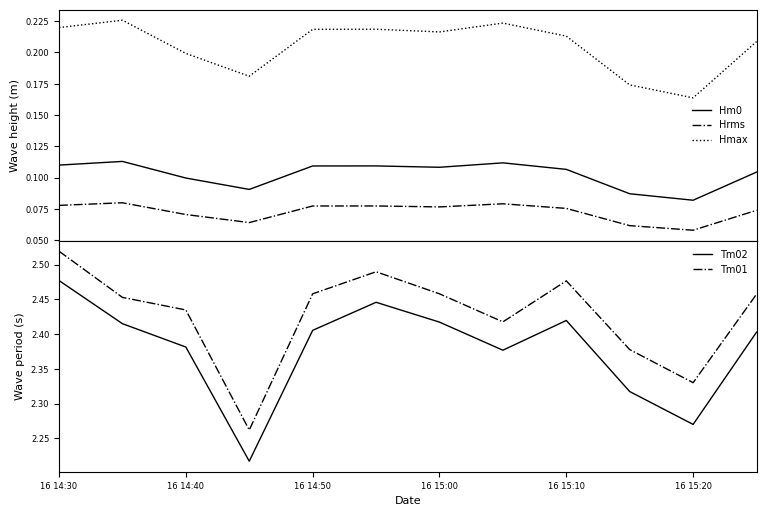

In [17]:
fig, (ax0, ax1) = plt.subplots(figsize=(9,6), nrows=2, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(Wwave_time, W_Hm0, lw=1, c='k', label='Hm0')
ax0.plot(Wwave_time, W_Hrms, lw=1, c='k', ls='-.', label='Hrms')
ax0.plot(Wwave_time, W_Hmax, lw=1, c='k', ls=':', label='Hmax')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Wave height (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
ax0.legend(loc=0,frameon=False)

ax1.plot(Wwave_time, W_Tm02, lw=1, c='k', label='Tm02')
ax1.plot(Wwave_time, W_Tm01, lw=1, c='k', ls='-.', label='Tm01')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Wave period (s)', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(Wwave_time[0],Wwave_time[-1])
ax1.legend(loc=0,frameon=False)

plt.show()

## For gravity waves

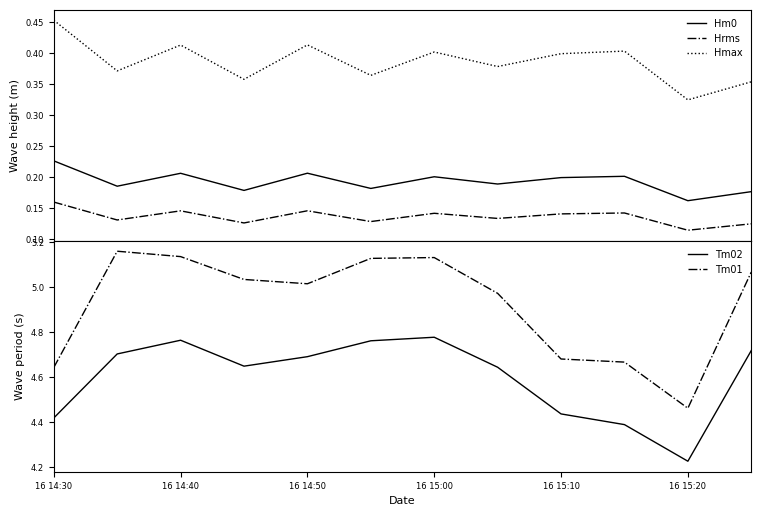

In [18]:
plt.rc('legend',**{'fontsize':7})

fig, (ax0, ax1) = plt.subplots(figsize=(9,6), nrows=2, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(Gwave_time, G_Hm0, lw=1, c='k', label='Hm0')
ax0.plot(Gwave_time, G_Hrms, lw=1, c='k', ls='-.', label='Hrms')
ax0.plot(Gwave_time, G_Hmax, lw=1, c='k', ls=':', label='Hmax')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Wave height (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
ax0.legend(loc=0,frameon=False)

ax1.plot(Gwave_time, G_Tm02, lw=1, c='k', label='Tm02')
ax1.plot(Gwave_time, G_Tm01, lw=1, c='k', ls='-.', label='Tm01')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Wave period (s)', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(Gwave_time[0],Gwave_time[-1])
ax1.legend(loc=0,frameon=False)

plt.show()

## For infragravity waves

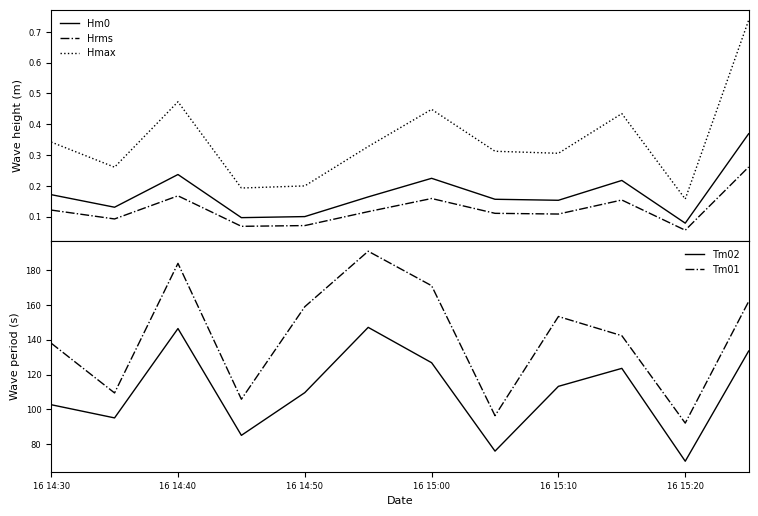

In [19]:
fig, (ax0, ax1) = plt.subplots(figsize=(9,6), nrows=2, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(IGwave_time, IG_Hm0, lw=1, c='k', label='Hm0')
ax0.plot(IGwave_time, IG_Hrms, lw=1, c='k', ls='-.', label='Hrms')
ax0.plot(IGwave_time, IG_Hmax, lw=1, c='k', ls=':', label='Hmax')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Wave height (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
ax0.legend(loc=0,frameon=False)

ax1.plot(IGwave_time, IG_Tm02, lw=1, c='k', label='Tm02')
ax1.plot(IGwave_time, IG_Tm01, lw=1, c='k', ls='-.', label='Tm01')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Wave period (s)', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(IGwave_time[0],IGwave_time[-1])
ax1.legend(loc=0,frameon=False)

plt.show()

## Now look at the power spectra:

We can use a Fast Fourier Transform to look at the data in the frequency domain.
<br>
![alt text](../data/images/FFT.png "An FFT converts a signal into its frequency components")
<i><br>An FFT converts a signal into its frequency components

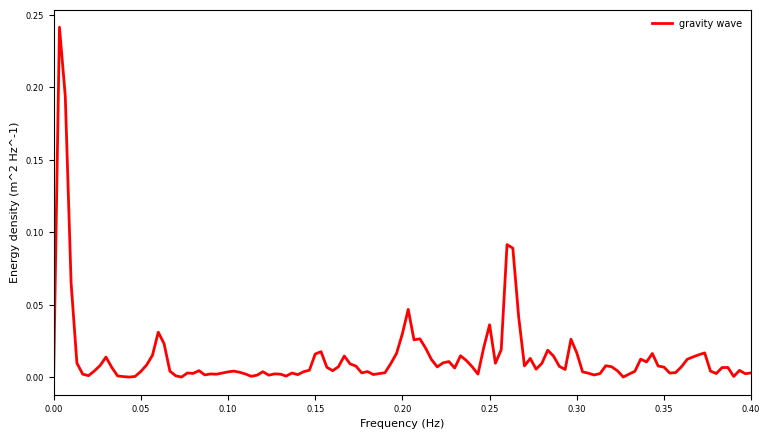

In [20]:
fig, ax0 = plt.subplots(figsize=(9,5), nrows=1, sharex=True, 
                        gridspec_kw={'hspace': 0})
ax0.plot(G_fspec, G_s[:-1], lw=2, c='r', label='gravity wave')
# ax0.plot(IG_fspec, IG_s, lw=2, c='b', label='infragravity wave')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Energy density (m^2 Hz^-1)', fontsize=8)
plt.xlabel('Frequency (Hz)', fontsize=8)
plt.xlim(G_fspec.min(),G_fspec.max())
plt.xlim(0,0.4)
ax0.legend(loc=1,frameon=False)
plt.show()

<p style="color:red"> <font size="3"> <b>
Now, lets look at the data from Maroubra so we can compare the two beaches.
    
Open the notebook Part_3_Maroubra
